In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  24#@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 13s 0us/step


In [0]:
import os
from os import listdir
from os.path import join
 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
 
 
 
 
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
 
def save_tf_records(x_train, y_train, out_path):
    writer = tf.python_io.TFRecordWriter(out_path)
 
    for i in range(y_train.shape[0]):
   
        example = tf.train.Example(features=tf.train.Features(
            feature={'image': _bytes_feature(x_train[i].tostring()),
                     'labels': _bytes_feature(
                         y_train[i].tostring())
                     }))
 
        writer.write(example.SerializeToString())
 
    writer.close()

In [0]:
save_tf_records(x_train, y_train, './training.tf_records')

In [0]:
def load_tf_records(path):
    dataset = tf.data.TFRecordDataset(path)
 
    def parser(record):
        featdef = {
            'image': tf.FixedLenFeature(shape=[], dtype=tf.string),
            'labels': tf.FixedLenFeature(shape=[], dtype=tf.string),
        }
 
        example = tf.parse_single_example(record, featdef)
        im = tf.decode_raw(example['image'], tf.float32)
        im = tf.reshape(im, (-1, 40, 40, 3))
        lbl = tf.decode_raw(example['labels'], tf.int64)
        return im, lbl
 
    dataset = dataset.map(parser)
    #dataset = dataset.shuffle(buffer_size=50000)
    dataset = dataset.batch(50000)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [13]:
x_train,y_train = load_tf_records('./training.tf_records')




Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [14]:
x_train.shape


TensorShape([Dimension(50000), Dimension(1), Dimension(40), Dimension(40), Dimension(3)])

In [0]:
##Implementing CutOut
def get_random_eraser(input_img,p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    #cutout
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
    
    return eraser(input_img)


def tf_Cutout_image(image , label):
  imshape = image.shape
  [image,] = tf.py_function(get_random_eraser,[image],[tf.float32])
  image.set_shape(imshape)
  return image 

  

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1
last_batch_size = len_train % BATCH_SIZE

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf_Cutout_image(tf.random_crop(x, [32, 32, 3]),y)), y)

In [0]:
data_aug = lambda x, y: (get_random_eraser(tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))),y)

In [0]:
#data_aug = lambda x, y: (tf.image.random_flip_left_right(x, y))

In [0]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
#eraser = get_random_eraser()
def augmentation(x, y):
    # x = tf.image.resize_with_crop_or_pad(
    #     x, HEIGHT + 8, WIDTH + 8)
    # x = tf.image.random_crop(x, [-1,HEIGHT, WIDTH, NUM_CHANNELS])
    # x = tf.image.random_brightness(x, max_delta=0.5)
    # x = tf.image.random_contrast(x, lower=0.5,upper=1.5)
    #x = tf_Cutout_image(x , y)
    #x = eraser(x)
    x = tf.image.random_flip_left_right(x)
    return x, y

In [0]:
epochArray=[]
trainAcc=[]
valAcc=[]


In [20]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(augmentation).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len_train).batch(BATCH_SIZE).prefetch(1) 
  
  #Since you are using dataset.prefetch(buffer_size=1) after dataset.batch(), it means that it will prefetch 1 batch.

  tf.keras.backend.set_learning_phase(1)
  batch_count = 0
  for (x, y) in tqdm(train_set):
    batch_count += 1
    if batch_count <batches_per_epoch :
        x = tf.reshape(x, [BATCH_SIZE,40,40,3])
        y = tf.reshape(y, [BATCH_SIZE])
    else:
        x = tf.reshape(x, [last_batch_size,40,40,3])
        y = tf.reshape(y, [last_batch_size])
        
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  epochArray.append(epoch)
  trainAcc.append(train_acc / len_train)
  valAcc.append(test_acc / len_test)
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.533936390991211 train acc: 0.44912 val loss: 1.3757981842041016 val acc: 0.5062 time: 85.23270630836487



epoch: 2 lr: 0.16 train loss: 0.7879799639892578 train acc: 0.72018 val loss: 1.0566308563232423 val acc: 0.6443 time: 145.2716362476349



epoch: 3 lr: 0.24 train loss: 0.5716288928222656 train acc: 0.8015 val loss: 1.327951300048828 val acc: 0.5817 time: 206.3998396396637



epoch: 4 lr: 0.32 train loss: 0.48586107055664063 train acc: 0.83544 val loss: 0.8155050567626954 val acc: 0.7282 time: 268.09465980529785



epoch: 5 lr: 0.4 train loss: 0.3953464419555664 train acc: 0.86496 val loss: 0.8005592361450196 val acc: 0.7218 time: 330.0118262767792



epoch: 6 lr: 0.37894736842105264 train loss: 0.29550330490112303 train acc: 0.89776 val loss: 0.6843132797241211 val acc: 0.7727 time: 391.93467259407043



epoch: 7 lr: 0.35789473684210527 train loss: 0.20458391021728517 train acc: 0.93046 val loss: 0.5890649765014648 val acc: 0.8088 time: 453.91218638420105



epoch: 8 lr: 0.33684210526315794 train loss: 0.14082211776733397 train acc: 0.95246 val loss: 0.5475226455688477 val acc: 0.8191 time: 515.8525094985962



epoch: 9 lr: 0.31578947368421056 train loss: 0.09434126667022705 train acc: 0.97004 val loss: 0.4691668365478516 val acc: 0.8465 time: 577.6126282215118



epoch: 10 lr: 0.2947368421052632 train loss: 0.06593792488098145 train acc: 0.9803 val loss: 0.47880583801269533 val acc: 0.8554 time: 639.4920449256897



epoch: 11 lr: 0.2736842105263158 train loss: 0.04169999614715576 train acc: 0.98828 val loss: 0.5314903854370118 val acc: 0.8437 time: 701.5259201526642



epoch: 12 lr: 0.25263157894736843 train loss: 0.025161177253723143 train acc: 0.9934 val loss: 0.4442239440917969 val acc: 0.8686 time: 763.4268667697906



epoch: 13 lr: 0.23157894736842108 train loss: 0.013482062554359436 train acc: 0.9972 val loss: 0.48554165954589845 val acc: 0.8604 time: 825.2310519218445



epoch: 14 lr: 0.2105263157894737 train loss: 0.008550964291095734 train acc: 0.99868 val loss: 0.46413294830322266 val acc: 0.8703 time: 887.1596713066101



epoch: 15 lr: 0.18947368421052635 train loss: 0.0049466076707839965 train acc: 0.99932 val loss: 0.4608890747070313 val acc: 0.875 time: 949.127977848053



epoch: 16 lr: 0.16842105263157897 train loss: 0.002862525852918625 train acc: 0.9997 val loss: 0.4383858184814453 val acc: 0.8801 time: 1011.1160500049591



epoch: 17 lr: 0.1473684210526316 train loss: 0.0019892355400323867 train acc: 0.99984 val loss: 0.4604327949523926 val acc: 0.8764 time: 1072.9466016292572



epoch: 18 lr: 0.12631578947368421 train loss: 0.0012909219098091126 train acc: 0.99996 val loss: 0.4626433837890625 val acc: 0.8779 time: 1134.325368642807



epoch: 19 lr: 0.10526315789473689 train loss: 0.0009969402039051057 train acc: 0.99998 val loss: 0.4671613906860352 val acc: 0.8772 time: 1195.8044345378876



epoch: 20 lr: 0.08421052631578951 train loss: 0.0008591793745756149 train acc: 1.0 val loss: 0.45754923782348633 val acc: 0.8814 time: 1257.0068142414093



epoch: 21 lr: 0.06315789473684214 train loss: 0.0007593252739310264 train acc: 1.0 val loss: 0.46319511489868165 val acc: 0.8794 time: 1318.3446769714355



epoch: 22 lr: 0.04210526315789476 train loss: 0.0007213398817181588 train acc: 1.0 val loss: 0.46117470703125 val acc: 0.8801 time: 1379.271544456482



epoch: 23 lr: 0.02105263157894738 train loss: 0.0006964287215471268 train acc: 1.0 val loss: 0.4646901596069336 val acc: 0.8794 time: 1440.287057876587



epoch: 24 lr: 0.0 train loss: 0.0006660141548514366 train acc: 1.0 val loss: 0.4623270393371582 val acc: 0.8803 time: 1501.6064381599426


In [0]:
import matplotlib.pyplot as plt

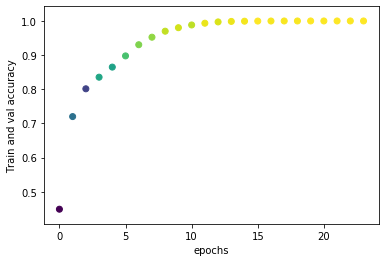

In [23]:
data = {'x': epochArray,
        'y1': trainAcc,
        'y2': valAcc}
plt.scatter('x', 'y1', c='y2', data=data)
plt.xlabel('epochs')
plt.ylabel('Train and val accuracy')
plt.show()

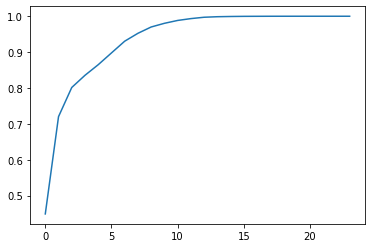

In [24]:
plt.plot(epochArray, trainAcc)
plt.show()

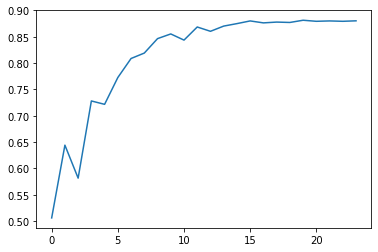

In [25]:
plt.plot(epochArray, valAcc)
plt.show()

In [0]:
# t = time.time()
# test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# for epoch in range(2):
#   train_loss = test_loss = train_acc = test_acc = 0.0
#   train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
#   #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(augmentation).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

#   tf.keras.backend.set_learning_phase(1)
#   for (x, y) in tqdm(train_set):
#     with tf.GradientTape() as tape:
#       loss, correct = model(x, y)

#     var = model.trainable_variables
#     grads = tape.gradient(loss, var)
#     for g, v in zip(grads, var):
#       g += v * WEIGHT_DECAY * BATCH_SIZE
#     opt.apply_gradients(zip(grads, var), global_step=global_step)

#     train_loss += loss.numpy()
#     train_acc += correct.numpy()

#   tf.keras.backend.set_learning_phase(0)
#   for (x, y) in test_set:
#     loss, correct = model(x, y)
#     test_loss += loss.numpy()
#     test_acc += correct.numpy()
    
#   print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

ValueError: ignored